In [647]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.optimize import minimize

#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf

from contextualized.easy import ContextualizedRegressor

In [648]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def difference(series, order=1):
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar

    X = X.dropna()
    y = series.loc[X.index]
    return X, y
    


In [649]:
def myARIMA2(p, i, q, df):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Includes an intercept and uses standard Linear Regression directly.
    """
    if not isinstance(df, pd.Series):
        df = pd.Series(df)

    original_series = df.copy()
    differenced_series = difference(df, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = LinearRegression()
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = LinearRegression()
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Final fit with AR + MA features
        regression_model = LinearRegression()
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,
        'intercept': intercept,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict

In [650]:
from sklearn.linear_model import Ridge

def myARIMA2(p, i, q, df, alpha=1.0):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Uses Ridge Regression with specified regularization strength alpha.
    """
    if not isinstance(df, pd.Series):
        df = pd.Series(df)

    original_series = df.copy()
    differenced_series = difference(df, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=alpha)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Final fit with AR + MA features
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,
        'intercept': intercept,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [651]:
def ContextualisedARIMA(p, i, q, df):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Includes an intercept and uses standard Linear Regression directly.
    """
    if not isinstance(df, pd.Series):
        df = pd.Series(df)

    original_series = df.copy()
    differenced_series = difference(df, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = LinearRegression()
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = LinearRegression()
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Final fit with AR + MA features
        regression_model = LinearRegression()
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,
        'intercept': intercept,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict

In [652]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [653]:
def rolling_forecast(model_dict, true_series):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    Args:
        model_dict: the fitted ARIMA model dictionary.
        true_series: the full true series (must be longer than the training data).
    Returns:
        predictions: list of one-step-ahead forecasts
    """
    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()

    start_idx = original_series.index[-1]  # where training data ends
    true_series = true_series[true_series.index > start_idx]  # only future part

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        # Combine features
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)

        # Predict differenced value
        diff_forecast = model.predict(X_pred)[0]

        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Now update histories **using the true observed value**
        true_value = true_series.loc[t_idx]

        # Update original_series
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])

        # Update differenced_series with new differenced value
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        # Update residuals (error between prediction and real observation)
        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [654]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

In [655]:
# read daily close price data
file_path1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
file_path2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_alltime.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Ensure that the date column is in datetime format
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
df2['qdate'] = pd.to_datetime(df2['qdate'])  # Financial ratios data
# Sort by qdate and public_date to ensure the most recent public_date comes last
df2_sorted = df2.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df2_latest = df2_sorted.drop_duplicates(subset='qdate', keep='last')
# Make a copy to avoid modifying the original df3_latest
df2_latest_pct = df2_latest.copy()
# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_latest_pct[columns_to_change] = df2_latest[columns_to_change].pct_change()

df = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2_latest_pct,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert df to a Pandas Series using the 'PRC' column
f = 'W-SUN' # 'W-SUN' means week ending on Sunday
df = df.resample(f).last()
df = df.dropna()

start_date = '2017-1-30'
end_train_date = '2018-9-30'

# Filter the data according to the date range
df = df[(df.index >= start_date)]
df_train = df[(df.index >= start_date) & (df.index <= end_train_date)]
df_test = df[(df.index >= df_train.index[-1])]

df_train.head()

,PERMNO,TICKER_x,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC,permno,adate,qdate,public_date,npm,de_ratio,curr_ratio,ptb,TICKER_y
date,,,,,,,,,,,,,,,,,
2017-02-05,11850.0,XOM,82.90,83.72,83.54,12746286.0,0.001079,83.70,11850.0,2016-12-31,2016-12-31,2017-04-30,-0.111111,-0.018888,0.010465,0.015357,XOM
2017-02-12,11850.0,XOM,82.13,82.77,82.52,8739814.0,0.008309,82.26,11850.0,2016-12-31,2016-12-31,2017-04-30,-0.111111,-0.018888,0.010465,0.015357,XOM
2017-02-19,11850.0,XOM,81.44,82.19,81.76,15645973.0,-0.006561,82.09,11850.0,2016-12-31,2016-12-31,2017-04-30,-0.111111,-0.018888,0.010465,0.015357,XOM
2017-02-26,11850.0,XOM,80.76,81.80,81.08,11338715.0,-0.008560,81.60,11850.0,2016-12-31,2016-12-31,2017-04-30,-0.111111,-0.018888,0.010465,0.015357,XOM
2017-03-05,11850.0,XOM,82.26,83.60,82.46,12304096.0,-0.010084,83.56,11850.0,2016-12-31,2016-12-31,2017-04-30,-0.111111,-0.018888,0.010465,0.015357,XOM


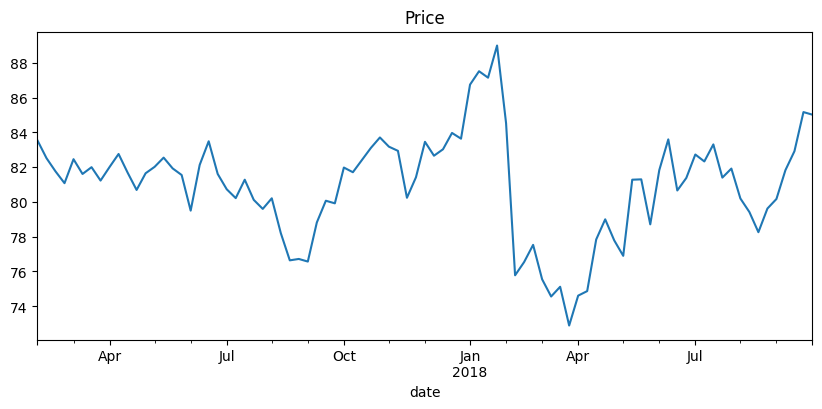

In [656]:
s = df['PRC']
s_train = df_train['PRC']
s_test = df_test['PRC']

c = df[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
c_train = df_train[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
c_test = df_test[['npm', 'de_ratio', 'curr_ratio', 'ptb']]

# Plot the series
s_train.plot(title='Price', figsize=(10, 4))
plt.show()


In [657]:
s_train.describe()
s_train.head()

date
2017-02-05    83.54
2017-02-12    82.52
2017-02-19    81.76
2017-02-26    81.08
2017-03-05    82.46
Freq: W-SUN, Name: PRC, dtype: float64

In [658]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(s_train)
# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [659]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(s)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


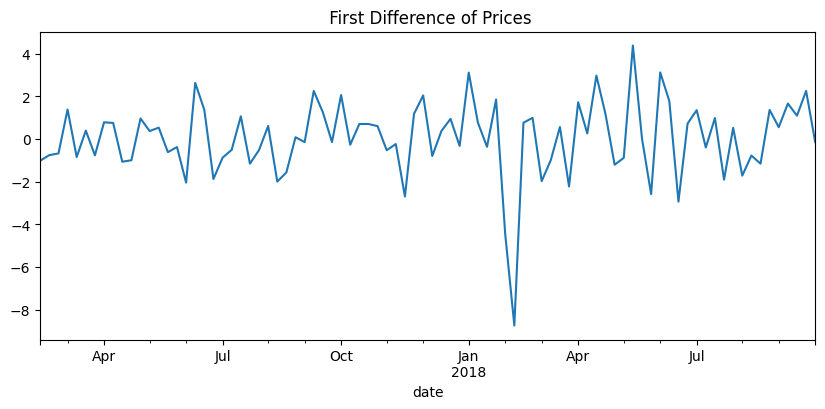

In [660]:
s_train_diffed = difference(s_train)

s_train_diffed.plot(title=' First Difference of Prices', figsize=(10, 4))
plt.show()

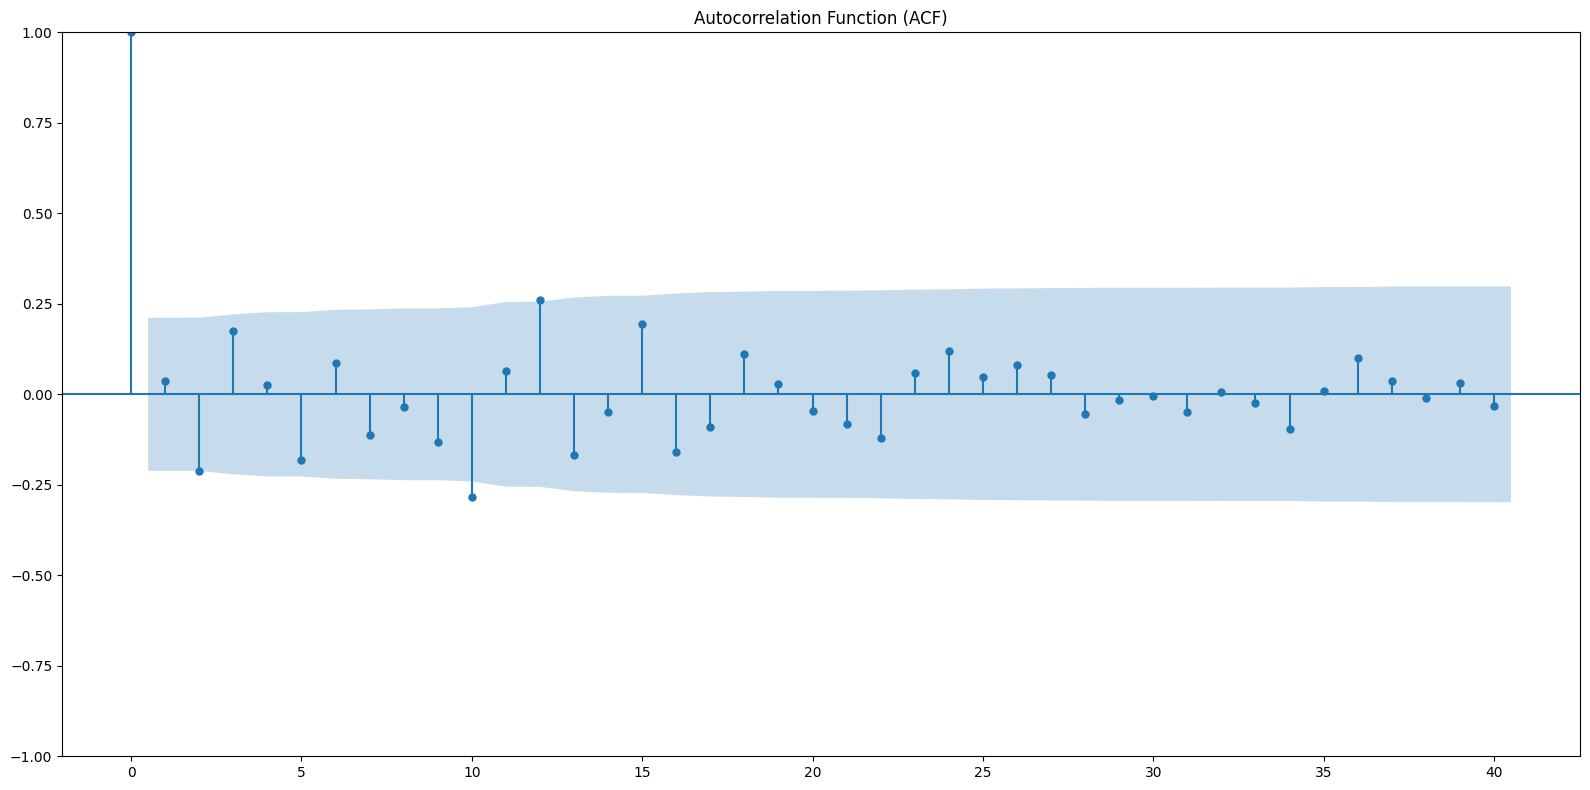

Significant ACF lags:
[2, 10, 12]


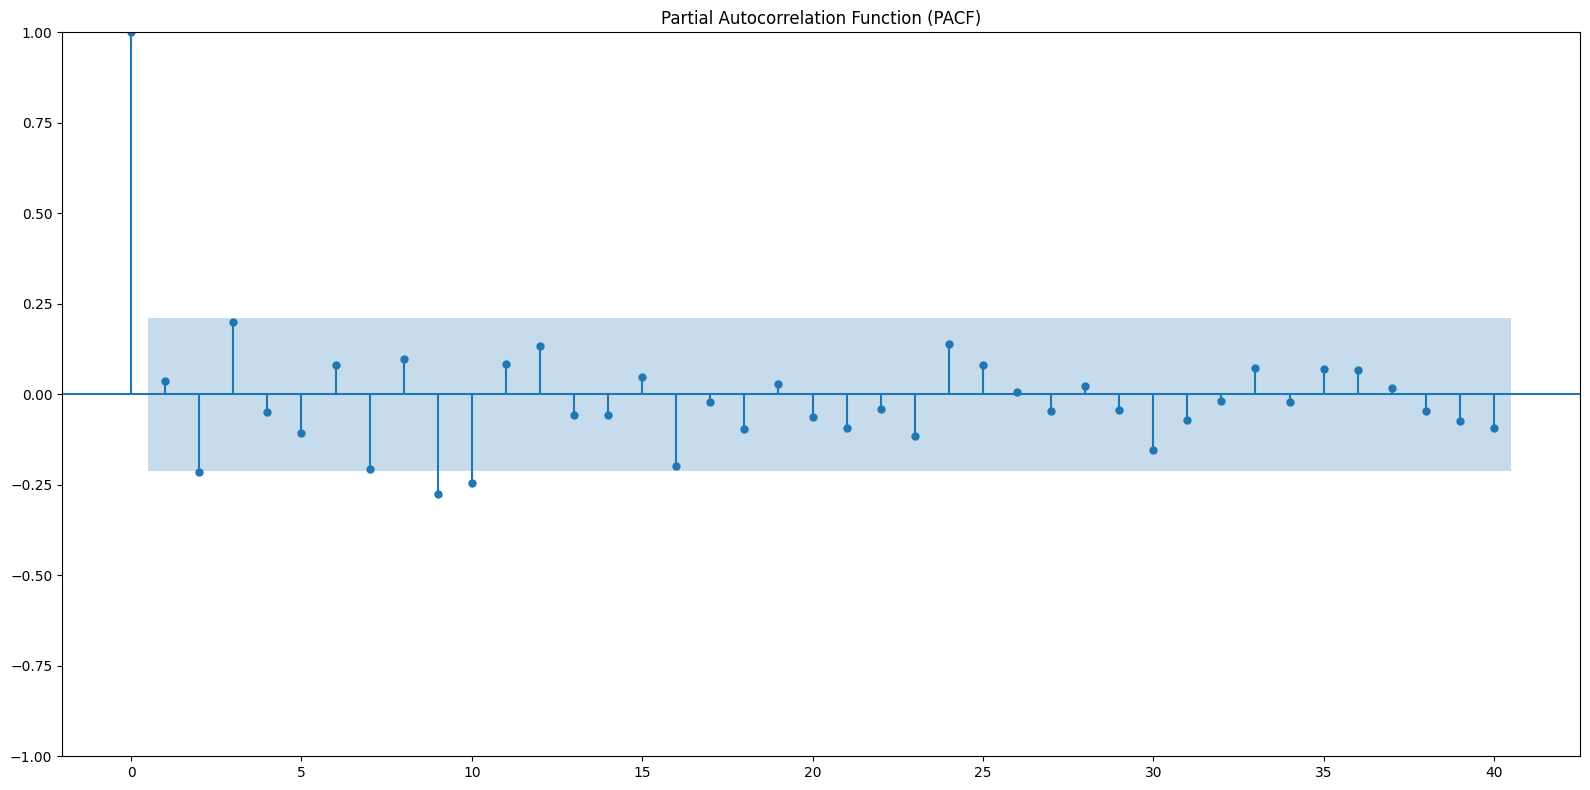

Significant PACF lags:
[2, 7, 9, 10, 16, 24, 30, 39, 40]


In [661]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(s_train_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(s_train_diffed)

print("Significant PACF lags:")
print(p)

In [662]:
#p = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 24, 30]

p = list(range(1,4))
q = [1,2,3]

# Fit the ARIMA model
model_dict = myARIMA2(p=p, i=1, q=q, df=s_train, alpha=1)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


Learned Parameters:
Intercept: 0.0322
Coefficients:
lag_1: -0.1984
lag_2: -0.2327
lag_3: 0.4851
ma_1: 0.3069
ma_2: 0.0375
ma_3: -0.3749


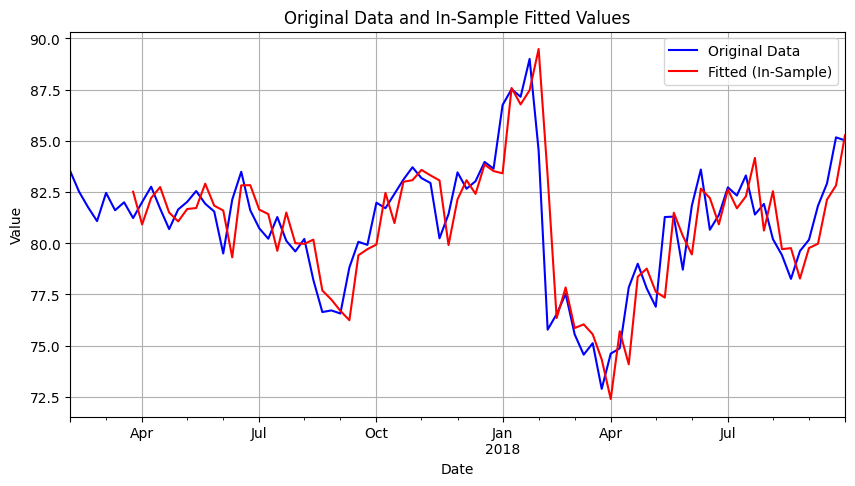

In [663]:
model = model_dict['model']
X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


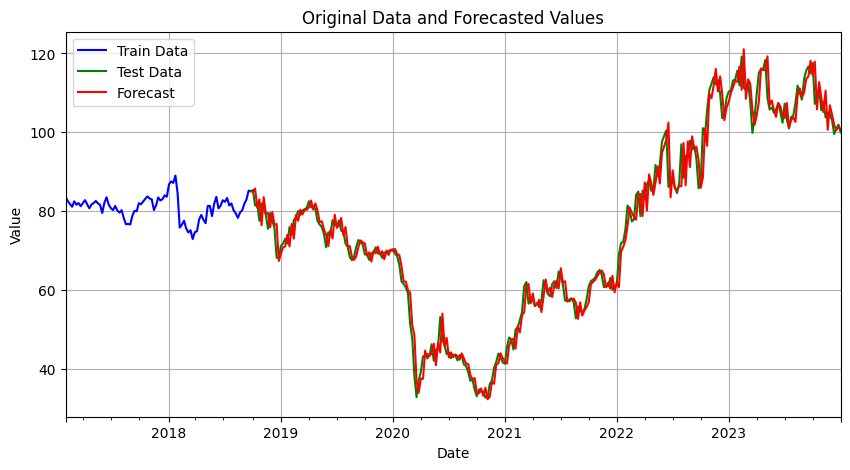

In [664]:
preds = rolling_forecast(model_dict, s)

# Get the last timestamp from the original series
last_date = s_train.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start=last_date + pd.Timedelta('1D'), periods=len(preds), freq='W-SUN')

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [668]:
preds


[84.80159377942276,
 85.710121859205,
 80.83730588173638,
 82.94506946228906,
 76.38874045668076,
 83.50370525833122,
 79.36492164062335,
 79.45815107074449,
 75.88540382168152,
 79.72995689995923,
 76.4068947967835,
 76.71129534362434,
 67.32471898847575,
 69.1758285696588,
 70.81961823659202,
 71.00351284308444,
 73.98650330821089,
 71.02642097656958,
 76.70272341709122,
 73.00150636887203,
 78.99922089812999,
 77.52220658094289,
 80.33629155233037,
 79.11845038204628,
 80.29064815340371,
 80.29536805567233,
 81.02015365562407,
 82.67166483578609,
 80.35394769400628,
 81.92698271305198,
 80.08355538068416,
 77.2049550560021,
 77.40769080229938,
 75.31396104362982,
 74.01406333741413,
 71.08888805046297,
 75.15818478983591,
 73.02529358779624,
 79.05378334983664,
 75.71791232120863,
 76.41471114807582,
 78.26406082520174,
 73.84051222113025,
 75.93882453551574,
 71.12875431000593,
 71.0680478744766,
 68.27356684602326,
 67.5963285415804,
 68.55185205557495,
 70.90981651501745,
 72.532

In [666]:
s_test

date
2018-09-30     85.02
2018-10-07     85.34
2018-10-14     81.38
2018-10-21     81.97
2018-10-28     77.53
               ...  
2023-12-03    102.99
2023-12-10     99.55
2023-12-17    100.90
2023-12-24    101.91
2023-12-31     99.98
Freq: W-SUN, Name: PRC, Length: 275, dtype: float64